In [11]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [12]:
warnings.filterwarnings("ignore")

In [13]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1000)

## Load data

In [14]:
df = pd.read_csv("../data/interim/data_processed.csv")

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Жилая площадь, м^2              644 non-null    float64
 1   Площадь кухни, м^2              644 non-null    float64
 2   Общая площадь, м^2              644 non-null    float64
 3   Этаж                            644 non-null    int64  
 4   Стоимость, р.                   644 non-null    int64  
 5   Количество комнат               644 non-null    int64  
 6   Тип жилья                       5 non-null      object 
 7   Планировка                      1 non-null      object 
 8   Высота потолков                 2 non-null      object 
 9   Санузел                         3 non-null      object 
 10  Ремонт                          5 non-null      object 
 11  Вид из окон                     4 non-null      object 
 12  Балкон/лоджия                   0 no

In [15]:
df.head()

,"Жилая площадь, м^2","Площадь кухни, м^2","Общая площадь, м^2",Этаж,"Стоимость, р.",Количество комнат,Тип жилья,Планировка,Высота потолков,Санузел,Ремонт,Вид из окон,Балкон/лоджия,Количество пассажирских лифтов,Год постройки,Количество грузовых лифтов,Количество этажей,Технология строительства,Район,Станция метро,Широта,Долгота
0,31.2,37.1,88.6,5,18500000,2,Вторичка,Смежно-изолированная,"2,8 м",NaN,Без ремонта,На улицу,NaN,2,2021.0,0,7,monolithBrick,Выборгский,Черная речка,59.997477,30.328838
1,17.5,5.5,31.3,4,8120000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1962.0,0,5,brick,Василеостровский,Приморская,59.938383,30.240625
2,56.0,21.0,97.0,10,24000000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2006.0,1,17,monolith,Василеостровский,Приморская,59.954773,30.214808
3,18.0,9.2,40.3,15,11500000,1,Вторичка,NaN,"2,75 м",NaN,Евроремонт,NaN,NaN,1,2012.0,1,19,monolith,Калининский,Академическая,60.011752,30.388434
4,0.0,0.0,40.4,3,14900000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2013.0,0,7,monolith,Центральный,Маяковская,59.926242,30.366488


In [16]:
df.shape

(644, 22)

## EDA

## Missing values

In [17]:
df.isnull().mean() * 100

Жилая площадь, м^2                  0.000000
Площадь кухни, м^2                  0.000000
Общая площадь, м^2                  0.000000
Этаж                                0.000000
Стоимость, р.                       0.000000
Количество комнат                   0.000000
Тип жилья                          99.223602
Планировка                         99.844720
Высота потолков                    99.689441
Санузел                            99.534161
Ремонт                             99.223602
Вид из окон                        99.378882
Балкон/лоджия                     100.000000
Количество пассажирских лифтов      0.000000
Год постройки                      17.857143
Количество грузовых лифтов          0.000000
Количество этажей                   0.000000
Технология строительства            8.695652
Район                               0.000000
Станция метро                      14.751553
Широта                              0.000000
Долгота                             0.000000
dtype: flo

## Correlation

In [18]:
def plot_correlation_matrix(df: pd.DataFrame) -> None:
    """Plot Pearson correlation matrix.

    @param df: input dataset
    """
    corr_pearson = df.corr(method='pearson')
    plt.figure(figsize=(16, 6))
    heatmap = sns.heatmap(corr_pearson, vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 12}, pad=12)

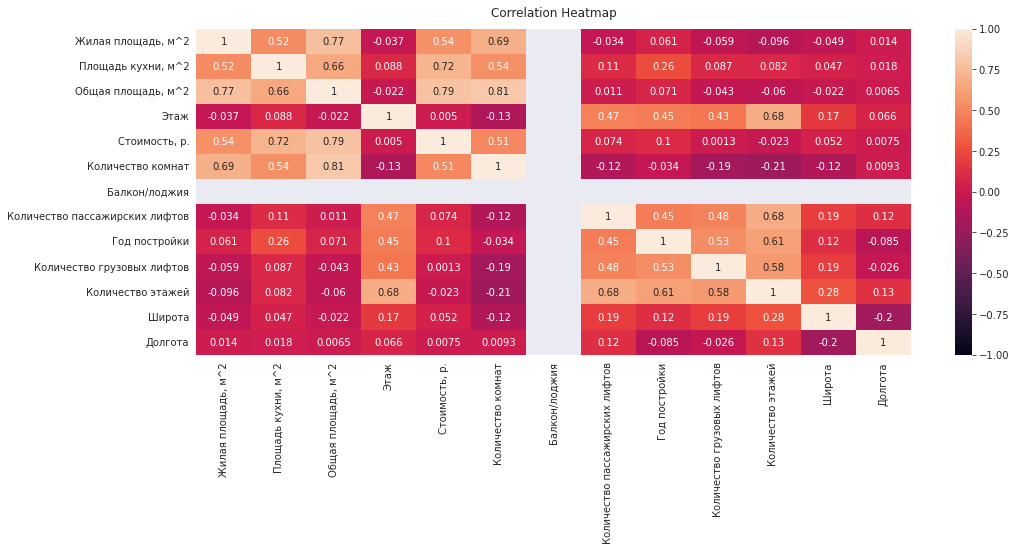

In [19]:
plot_correlation_matrix(df=df)

## Distributions

### Target

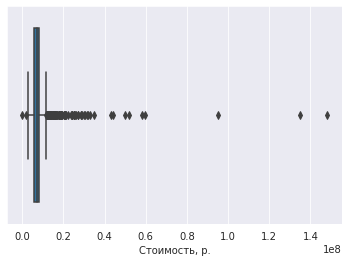

In [22]:
sns.boxplot(df['Стоимость, р.']);

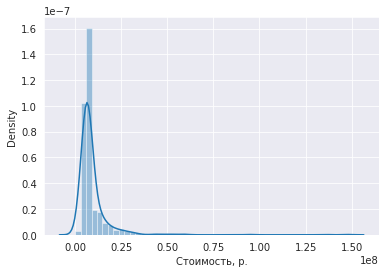

In [24]:
sns.distplot(df['Стоимость, р.']);

### Numerical features

In [51]:
def plot_distribution_of_numeric_features(df: pd.DataFrame) -> None:
    """Plot distribution of numeric features.

    @param df: input data
    """
    df = df.select_dtypes(exclude=['object'])
    fig, axs = plt.subplots(
        4, 4, figsize=(15, 10), facecolor='w', edgecolor='k')
    fig.suptitle('Numeric features distribution')
    plt.subplots_adjust(hspace=2.5)
    axs = axs.ravel()
    columns = list(df.columns)
    for i in range(len(columns)):
        axs[i].set_title(columns[i])
        sns.distplot(df[columns[i]], ax=axs[i])


def plot_boxplot_of_numeric_features(df: pd.DataFrame) -> None:
    """Plot boxplot of numeric features.

    @param df: input data
    """
    df = df.select_dtypes(exclude=['object'])
    fig, axs = plt.subplots(
        4, 4, figsize=(15, 10), facecolor='w', edgecolor='k')
    fig.suptitle('Numeric features distribution')
    plt.subplots_adjust(hspace=2.5)
    axs = axs.ravel()
    columns = list(df.columns)
    for i in range(len(columns)):
        axs[i].set_title(columns[i])
        sns.boxplot(df[columns[i]], ax=axs[i])

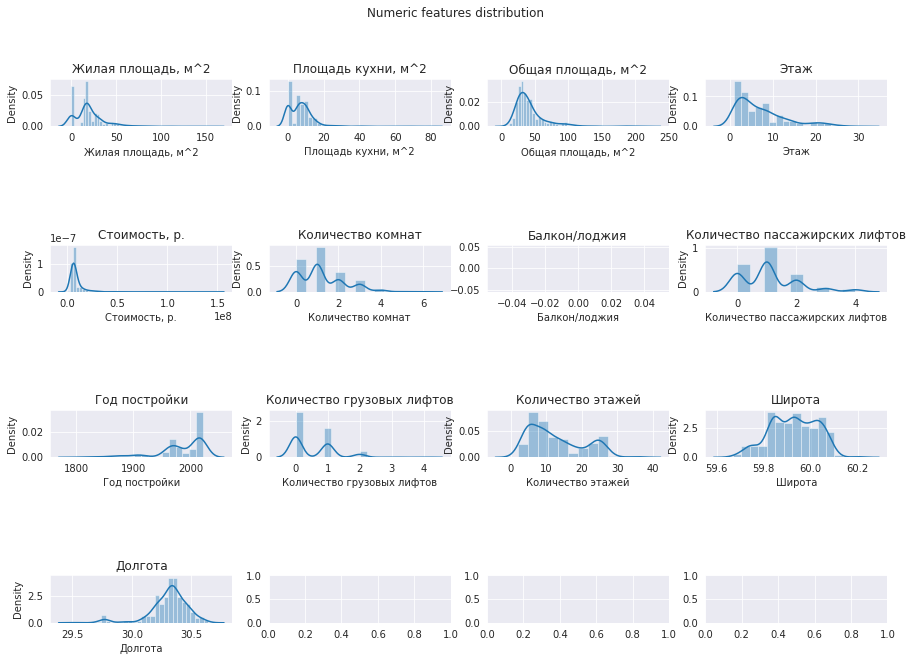

In [52]:
plot_distribution_of_numeric_features(df=df)

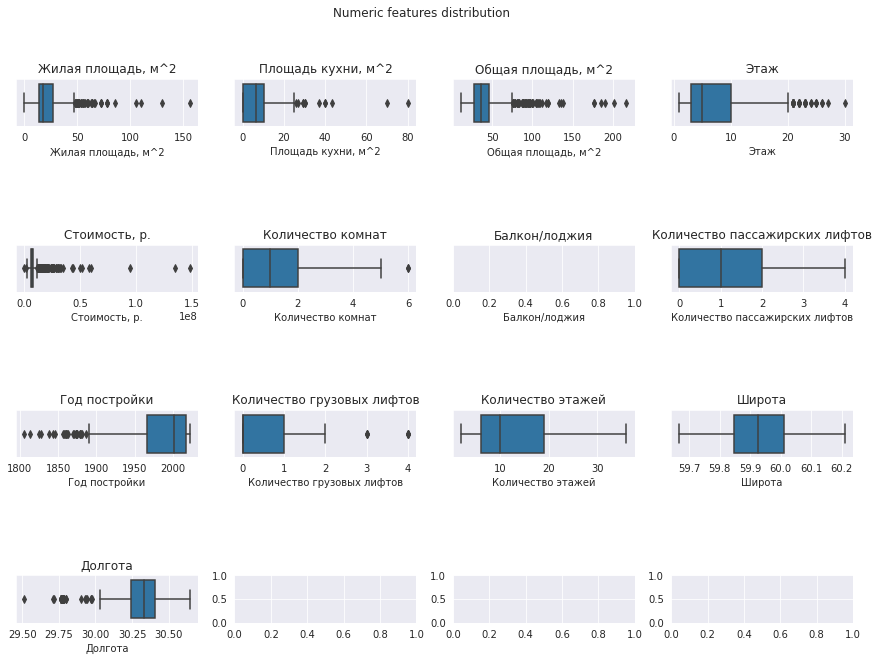

In [53]:
plot_boxplot_of_numeric_features(df=df)

## Categorical features

In [64]:
def countplot_of_cat_features(df: pd.DataFrame) -> None:
    """Countplot bars of categorical features.

    @param df: input data
    """
    df = df.select_dtypes(include=['object'])
    fig, axs = plt.subplots(
        3, 3, figsize=(15, 10), facecolor='w', edgecolor='k')
    fig.suptitle('Numeric features distribution')
    plt.subplots_adjust(hspace=2.5)
    axs = axs.ravel()
    columns = list(df.columns)
    for i in range(len(columns)):
        axs[i].set_title(columns[i])
        df.groupby(columns[i])[columns[i]].agg(['count']).plot(kind='bar', ax=axs[i])

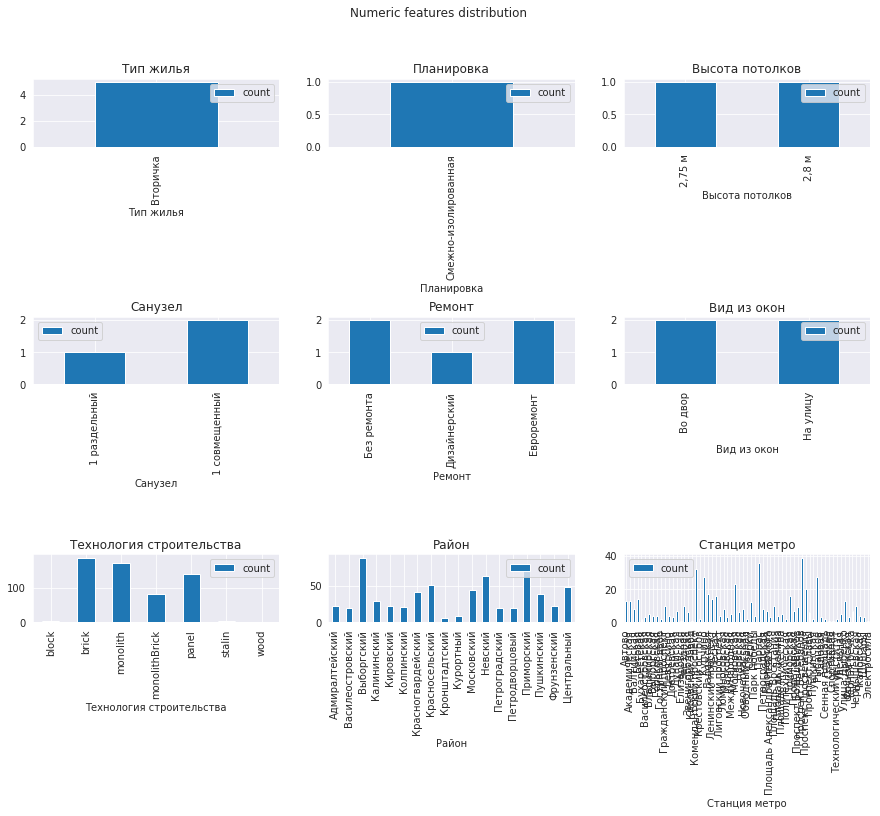

In [65]:
countplot_of_cat_features(df=df)